<center><img src="./images/nup_logo_dark.jpeg" width=300 style="display: inline-block;"></center> 

## Advanced ML
### Practice on Autoencoders and Generative Adversarial Networks

<br />
March 4, 2025


Source: https://github.com/andriygav/MachineLearningSeminars/tree/master/sem16

In [1]:
import math
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
import os
from urllib.request import urlopen
from skimage.segmentation import mark_boundaries
from torch import nn

from tqdm.notebook import tqdm
import numpy as np
import requests
from scipy.stats import norm
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

# Tensorboard

In [4]:
%load_ext tensorboard
%tensorboard --logdir ./

## Code for training

In [5]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total


In [6]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

## Autoencoder

In [7]:
digit_size = (28, 28)

In [8]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device))
    
    loss = loss_function(output, x_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

<div class="alert alert-info">
<b>Questions</b>  What is the output? What loss function we need to use?
</div>

In [9]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            model.eval()
            for it, (x_batch, _) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)

                output = model(x_batch)

                test_loss += self.loss_function(output, x_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

            x = x_batch[-10:]
            
            fig = plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
            gs = gridspec.GridSpec(1, x.shape[0])
            for i in range(x.shape[0]):
                ax = fig.add_subplot(gs[i])
                ax.imshow(model(x.to(model.device)).cpu().data[i].view(*digit_size).numpy(), cmap='Greys_r', interpolation='lanczos')
                ax.axis('off')
                    
            self.writer.add_figure('VISUAL/decoded', fig, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

### Linear autoencoder

#### Data

In [10]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor, 
                                 lambda x: x.view(784)])

In [11]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True,
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

In [12]:
for x_batch, y_batch in torch.utils.data.DataLoader(dataset=MNIST_train, batch_size=64, shuffle=True):
    pass

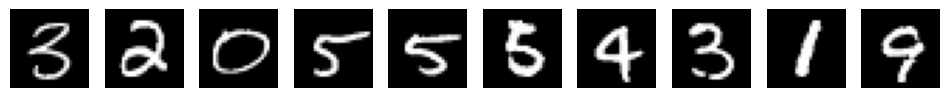

In [13]:
xs = x_batch[-10:]
plt.figure(figsize=(12, 12 / 10 * (x_batch.shape[0] // 10 + 1)))
for i in range(xs.shape[0]):
    plt.subplot(xs.shape[0] // 10 + 1, 10, i + 1)
    plt.imshow(xs.data[i].view(*digit_size).numpy(), cmap='Greys_r') #, interpolation='lanczos')
    plt.axis('off')
        
plt.show()

#### First model

In [14]:
class Encoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(object_dim, d)
        
    def forward(self, x):
        return self.linear(x)

In [15]:
class Decoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, object_dim):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.linear = torch.nn.Linear(d, object_dim)
        
    def forward(self, x):
        return self.linear(x)

In [16]:
class Autoencoder(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, object_dim, d):
        super(type(self), self).__init__()
        self.object_dim = object_dim
        self.d = d
        
        self.encoder = Encoder(np.prod(digit_size), d)
        self.decoder = Decoder(d, np.prod(digit_size))
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

#### Model optimization

In [17]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam

#### Iterating over different d: training the model

In [18]:
for d in [2, 4, 8, 16, 32, 64]:
    autoencoder = Autoencoder(np.prod(digit_size), d)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-linear/{}'.format(d))

    call = callback(writer, MNIST_test, loss_function, delimeter=100)

    trainer(count_of_epoch=5, 
            batch_size=64, 
            dataset=MNIST_train,
            model=autoencoder, 
            loss_function=loss_function,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Neural network autoencoder

In [19]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor])

In [20]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

#### Model

<div class="alert alert-info">
<b>Questions</b>  Where is `d` used? What does the picture turn into at the output of the encoder?
</div>

In [21]:
class EncoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d
# 28x28x1
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(1, 6, kernel_size = 5))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(6))
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size = 2)) # 12x12x6
        
        self.layers.add_module('conv2', torch.nn.Conv2d(6, 16, kernel_size = 5)) # 8x8x16
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(16))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size = 2)) # 4x4x16
        
        self.layers.add_module('conv3', torch.nn.Conv2d(16, self.d, kernel_size = 3)) # 2x2xd
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('pool3', torch.nn.MaxPool2d(kernel_size = 2)) # 1x1xd

        self.layers.add_module('flatten', torch.nn.Flatten())

    def forward(self, input):
        return self.layers(input)

In [22]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

In [23]:
class DecoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d

        self.layers = torch.nn.Sequential()
        self.layers.add_module('reshape1', Reshape(self.d, 1, 1))
        
        self.layers.add_module('conv1', torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False))
        self.layers.add_module('bnorm1', torch.nn.BatchNorm2d(128))
        self.layers.add_module('relu1', torch.nn.ReLU())
        
        self.layers.add_module('conv2', torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False))
        self.layers.add_module('bnorm2', torch.nn.BatchNorm2d(64))
        self.layers.add_module('relu2', torch.nn.ReLU())
        
        self.layers.add_module('conv3', torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False))
        self.layers.add_module('bnorm3', torch.nn.BatchNorm2d(32))
        self.layers.add_module('relu3', torch.nn.ReLU())

        self.layers.add_module('conv4', torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False))
        # 28x28x1
        self.layers.add_module('sigmoid', torch.nn.Sigmoid())
        
    def forward(self, x):
        return self.layers(x)

<div class="alert alert-info">
<b>Question</b> Why is there a sigmoid at the end?
</div>

In [24]:
class AutoencoderCNN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d):
        super(type(self), self).__init__()
        self.d = d
        
        self.encoder = EncoderCNN(d)
        self.decoder = DecoderCNN(d)
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

#### Model optimization

In [25]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam

#### Iterating over different `d`: training the model

In [26]:
for d in [2, 4, 8, 16, 32, 64]:
    autoencoder = AutoencoderCNN(d)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-cnn/{}'.format(d))
    call = callback(writer, MNIST_test, loss_function, delimeter = 100)

    trainer(count_of_epoch=5, 
            batch_size=64, 
            dataset=MNIST_train,
            model=autoencoder, 
            loss_function=loss_function,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

### Variational autoencoder

Instead of vectors (data), both the encoder and the decoder produce vectors of distribution parameters.

#### Model

In [27]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=200):
        """
        Standart model of VAE with evidence lower bound (ELBO) optimization.
        Args:
            latent_dim: int - the dimension of latent space
            input_dim: int - the dimension of input space
            hidden_dim: int - the size of hidden_dim neural layer
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU(),
        )
        self.proposal_mu = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma = torch.nn.Linear(hidden_dim, self.latent_dim)

        self.generative_network = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
            torch.nn.Sigmoid()
        )

    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape (batch_size, input_dim)
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters
            mu: Tensor - the matrix of shape (batch_size, latent_dim)
            sigma: Tensor - the matrix of shape (batch_size, latent_dim)
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim],
                              requires_grad=True,
                              device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        # reparametrization trick
        return bias + epsilon * scale 

    def q_x(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Bernoulli distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Example:
            >>>
        """
        z = z.to(self.device)
        out = self.generative_network(z)

        return torch.clamp(out, 0.01, 0.99)

    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)
#         batch_y = batch_y.to(self.device)

        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        x_distr = self.q_x(self.sample_z(propos_distr))

        # likelihood of a Bernoulli distribution
        # (such a formula for computational stability)
        expectation = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr)), dim=0)

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * torch.mean(expectation - divergence, dim=0)

    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Args:
            num_samples: int — the number of samples to generate
        Returns:
            Tensor — the matrix of shape num_samples x input_dim
        Example:
            >>>
        """
        distr_z = self.p_z(num_samples=1)

        z = self.sample_z(distr_z, num_samples=num_samples)

        distr_x = self.q_x(z).view([num_samples, -1])

        return torch.bernoulli(distr_x, device=self.device)

    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Calculate a log likelihood between x_true and x_distr.
        Args:
            x_true:  Tensor — the matrix of shape batch_size x input_dim
            x_distr: Tensor — the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters
        Returns:
            Tensor — the matrix of shape batch_size x num_samples — log likelihood for each sample
        Example:
            >>>
        """
        batch_size = x_distr.shape[0]
        input_dim = x_distr.shape[2]

        bernoulli_log_likelihood = torch.log(
            x_distr) * x_true.view([batch_size, 1, input_dim])
        bernoulli_log_likelihood += torch.log(1 - x_distr) * (
            1 - x_true).view([batch_size, 1, input_dim])

        return torch.sum(bernoulli_log_likelihood, dim=2)

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor — the tensor of shape n_1 x n_2 x ... x n_K
        Returns:
            Tensor — the tensor of shape n_1 x n_2 x ... x n_{K - 1}
        Example:
            >>>
        """

        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))

    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) — the normal distribution parameters
                mu: Tensor — the matrix of shape batch_size x latent_dim
                sigma: Tensor — the matrix of shape batch_size x latent_dim
            p_distr=(mu, sigma): tuple(Tensor, Tensor) — the normal distribution parameters
                mu: Tensor — the matrix of shape batch_size x latent_dim
                sigma: Tensor — the matrix of shape batch_size x latent_dim
        Returns:
            Tensor — the vector of shape n, each value of which is a KL-divergence between pair of normal distribution
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - \
            2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL

    def forward(self, x):
        """
        Generate decoded sample after encoding.
        Args:
            x: Tensor — the matrix of shape (batch_size, input_dim)
        Returns:
            Tensor — the matrix of shape (batch_size, input_dim)
        Example:
            >>>
        """
        return self.q_x(self.sample_z(self.q_z(x))).view_as(x)


#### Code for VAE training

In [28]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    loss = model.loss(x_batch.to(model.device), y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

#### Data

In [29]:
preprocess = transforms.Compose([transforms.ToTensor(), 
                                 torch.FloatTensor, 
                                 lambda x: x.view(784)])

In [30]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=preprocess)

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=preprocess)

#### Model optimization

In [31]:
optimizer = torch.optim.Adam
# (!) not for learning, but for measuring quality on a test
loss_function = torch.nn.MSELoss()

#### Iterating over different sizes of latent space

In [32]:
# for d in [2]:
for d in [64, 32, 16, 8, 4, 2]:
    autoencoder = VAE(d, 28*28)
    autoencoder.to(device)

    writer = SummaryWriter(log_dir = 'autoencoder-vae/{}'.format(d))
    call = callback(writer, MNIST_test, loss_function, delimeter=100)

    trainer(count_of_epoch=10,
            batch_size=64,
            dataset=MNIST_train,
            model=autoencoder,
            loss_function=None,
            optimizer = optimizer,
            lr = 0.001,
            callback = call)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

#### Rendering the change (perturbing the hidden vectors)

In [33]:
def draw_samples_grid_vae(model,
                          num_row=15,
                          num_colum=15,
                          images_size=(28, 28)):
    """
    Illustrate how change digits x where change point in latent space z.
    Args:
        model: nn.Module — model VAE or IWAE
        num_row: int — the number of row
        num_colum: int — the number of column
        images_size = (x_size, y_size): tuple(int, int) — a size of input image
    Returns:
        figure: float — the picture
    Example:
        >>>
    """
    grid_x = norm.ppf(np.linspace(0.05, 0.95, num_colum))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, num_row))

    figure = np.zeros((images_size[0] * num_colum, images_size[1] * num_row))
    for i, y_i in enumerate(grid_x):
        for j, x_i in enumerate(grid_y):
            z_sample = np.array([[x_i, y_i]])

            x_sample = model.q_x(torch.from_numpy(z_sample).float()).view(
                images_size).cpu().data.numpy()

            image = x_sample
            figure[i * images_size[0]: (i + 1) * images_size[0],
                   j * images_size[1]: (j + 1) * images_size[1]] = image

    return figure

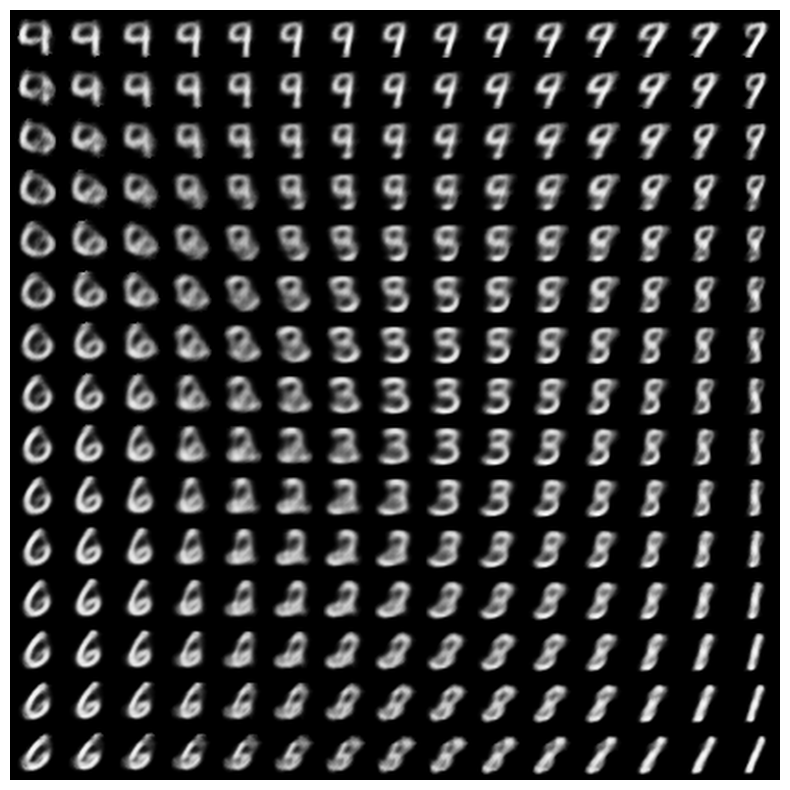

In [34]:
figure = draw_samples_grid_vae(autoencoder)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

## Transfer Learning

### Pre-trained models

#### Upload data of cats and dogs

In [35]:
# !wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
import urllib.request

urllib.request.urlretrieve('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip',
                           'cats_and_dogs_filtered.zip')

('cats_and_dogs_filtered.zip', <http.client.HTTPMessage at 0x3c5043500>)

In [36]:
# !unzip -qq cats_and_dogs_filtered.zip
import zipfile

with zipfile.ZipFile('cats_and_dogs_filtered.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [37]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalization from ImageNet data
])

# files in folders alphabetically
CatDogs_train = datasets.ImageFolder(root='cats_and_dogs_filtered/train/', 
                                     transform=preprocess)
CatDogs_test = datasets.ImageFolder(root='cats_and_dogs_filtered/validation/', 
                                     transform=preprocess)

#### Load the pre-trained model

In [38]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True, verbose=False)

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /Users/Aleksandr.Avdiushenko/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/Aleksandr.Avdiushenko/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.1MB/s]


In [39]:
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Code for training

In [40]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [41]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter = 100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size, 
                                                          pin_memory=True)
            
            pred = []
            real = []
            test_loss = 0
            model.eval()
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(device)

                output = model(x_batch)

                test_loss += self.loss_function(output, y_batch.to(device)).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)
            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

#### Model optimization

In [42]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

#### Quality before training

In [43]:
real = []
pred = []
for x_batch, y_batch in torch.utils.data.DataLoader(CatDogs_test, 
                                                    batch_size=64, 
                                                    shuffle=True, 
                                                    pin_memory=True):
  
    with torch.no_grad():
        output = model(x_batch.to(device))
    pred.extend(output.argmax(dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54       500
           1       0.55      0.58      0.57       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000



#### Model training

In [44]:
writer = SummaryWriter(log_dir='transfer-resnet18')
call = callback(writer, CatDogs_test, loss_function, delimeter=10)

trainer(count_of_epoch=10, 
        batch_size=64, 
        dataset=CatDogs_train,
        model=model,
        loss_function=loss_function,
        optimizer = optimizer,
        lr = 0.001,
        callback = call)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

#### Quality after training

In [45]:
real = []
pred = []
for x_batch, y_batch in torch.utils.data.DataLoader(CatDogs_test, 
                                                    batch_size = 64, 
                                                    shuffle = True, 
                                                    pin_memory=True):
  
    with torch.no_grad():
        output = model(x_batch.to(device))
    pred.extend(output.argmax(dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       500
           1       0.99      0.96      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



### GAN's for MNIST

In [46]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    optima_generator, optima_discriminator = optimizer
    
    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    
    discriminator_loss = model.discriminator_loss(x_batch)
    discriminator_loss.backward()
    optima_discriminator.step()

    optima_generator.zero_grad()
    optima_discriminator.zero_grad()
    
    generator_loss = model.generator_loss(len(x_batch))
    generator_loss.backward()
    optima_generator.step()
    
    return discriminator_loss.cpu().item() + generator_loss.cpu().item()

In [47]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(model.device), batch_of_y.to(model.device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [48]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    # here is the main difficulty in GANs — to choose the parameters so that training converges
    optima_generator = optimizer(model.generator.parameters(), lr=lr*10, betas=(0.5, 0.999))
    optima_discriminator = optimizer(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'epoch loss': np.nan})
    for it in iterations:        
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(
            train_generator=batch_generator, 
            model=model, 
            loss_function=loss_function, 
            optimizer=(optima_generator, optima_discriminator), 
            callback=callback)
        
        iterations.set_postfix({'epoch loss': epoch_loss})

#### Neural Network Model

In [49]:
class Reshape(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(type(self), self).__init__()
        self.dims = args

    def forward(self, input):
        return input.view(input.size(0), *self.dims)

class GAN(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, d, D):
        super(type(self), self).__init__()
        self.d = d
        self.discriminator = torch.nn.Sequential(
            Reshape(1, D, D),
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=0, bias=False),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.LeakyReLU(negative_slope=0.2),
            Reshape(-1),
            torch.nn.Linear(in_features=256, out_features=1),
            torch.nn.Sigmoid()
        )
        self.generator = torch.nn.Sequential(
            Reshape(self.d, 1, 1),
            torch.nn.ConvTranspose2d(self.d, 128, 4, 1, 0, 0, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, 3, 2, 1, 0, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, 3, 2, 1, 1, bias=False),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1, 0, bias=False),
            Reshape(-1),
            torch.nn.Sigmoid()
        )

    def generate_noise(self, num_samples):
        return torch.randn([num_samples, self.d], requires_grad=True).to(self.device)

    def generate_samples(self, num_samples):
        return self.generator(self.generate_noise(num_samples))

    def discriminator_loss(self, batch):
        loss = torch.nn.BCELoss()
        
        batch_size = batch.shape[0]
        
        fake_batch = self.discriminator(self.generate_samples(batch_size).detach())
        real_batch = self.discriminator(batch)
        
        fake_answ = torch.zeros(batch_size, 1).to(self.device)
        real_answ = torch.ones(batch.shape[0], 1).to(self.device)
        
        return 0.5*loss(fake_batch, fake_answ) + 0.5*loss(real_batch, real_answ)

    def generator_loss(self, batch_size):
        loss = torch.nn.BCELoss()
        
        fake_batch = self.discriminator(self.generate_samples(batch_size))
        
        real_answ = torch.ones(batch_size, 1).to(self.device)
            
        return loss(fake_batch, real_answ)
    
    def init_weight(self, mean, std):
        for m in self._modules:
            if isinstance(self._modules[m], nn.ConvTranspose2d) or isinstance(self._modules[m], nn.Conv2d):
                self._modules[m].weight.data.normal_(mean, std)
                self._modules[m].bias.data.zero_()


#### Model optimization

In [50]:
loss_function = None
optimizer = torch.optim.Adam

model = GAN(2, 28)
model.to(device)

GAN(
  (discriminator): Sequential(
    (0): Reshape()
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Reshape()
    (11): Linear(in_features=256, out_features=1, bias=True)
    (12): Sigmoid()
  )
  (generator): Sequential(
    (0): Reshape()
    (1): ConvTranspose2d(2, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReL

In [51]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())

MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

#### Helper functions

In [52]:
def show_images(x, digit_size=28):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    x = x.view(-1, digit_size, digit_size)
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(x.data[i].numpy(), cmap='Greys_r', interpolation='lanczos')
        plt.axis('off')

In [53]:
def generate_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(
            model.generate_samples(
                min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0).cpu().detach()

#### How data is generated before training

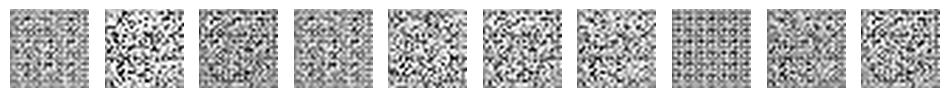

In [54]:
show_images(generate_samples(model, 10, 10))

#### Train model

In [55]:
trainer(count_of_epoch=10, 
        batch_size=64, 
        dataset=MNIST_train,
        model=model, 
        loss_function=loss_function,
        optimizer=optimizer,
        lr = 2e-4,
        callback = None)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

#### How data is generated after training

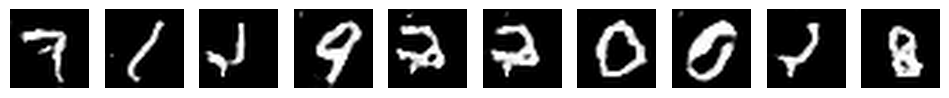

In [56]:
show_images(generate_samples(model, 10, 50))